In [ ]:
# Cell 1: Install & Import Dependencies
!pip install requests pandas numpy scipy matplotlib tqdm

import requests
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display

In [ ]:
# Cell 2: NSE API Helper Functions (with page‐load seeding)
session = requests.Session()
HEADERS = {
    "User-Agent":      "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer":         "https://www.nseindia.com",
}

def _prepare_session(symbol: str=None, page_type: str="home"):
    """
    Hit the NSE home page and, if symbol provided, the relevant quote page
    to seed cookies and headers.
    """
    session.get("https://www.nseindia.com", headers=HEADERS, timeout=5)
    if symbol and page_type=="equity":
        session.get(f"https://www.nseindia.com/get-quotes/equity?symbol={symbol}",
                    headers=HEADERS, timeout=5)
    elif symbol and page_type=="option_chain":
        session.get(f"https://www.nseindia.com/option-chain-equities?symbol={symbol}",
                    headers=HEADERS, timeout=5)
    elif symbol and page_type=="derivative":
        session.get(f"https://www.nseindia.com/get-quotes/derivatives?symbol={symbol}",
                    headers=HEADERS, timeout=5)

def _nse_get(url: str, **prep_kwargs) -> dict:
    """Seed correct pages, then fetch NSE JSON."""
    _prepare_session(**prep_kwargs)
    resp = session.get(url, headers=HEADERS, timeout=5)
    resp.raise_for_status()
    return resp.json()

def fetch_quote(symbol: str) -> dict:
    """Fetch current equity quote (spot) info."""
    url = f"https://www.nseindia.com/api/quote-equity?symbol={symbol}"
    data = _nse_get(url, symbol=symbol, page_type="equity")
    return data["priceInfo"]

def fetch_option_chain(symbol: str, expiry_date: str) -> pd.DataFrame:
    """
    Fetch full option chain for a specific expiry date and normalize into DataFrame.
    Args:
        symbol (str): The stock symbol (e.g., "RELIANCE").
        expiry_date (str): The desired expiry date in 'dd-MMM-yyyy' format (e.g., "29-May-2025").
    Returns:
        pd.DataFrame: Filtered option chain data for the given expiry date.
    """
    url = f"https://www.nseindia.com/api/option-chain-equities?symbol={symbol}"
    oc_json = _nse_get(url, symbol=symbol, page_type="option_chain")

    # Extract all available expiry dates
    available_expiry_dates = oc_json["records"]["expiryDates"]
    if expiry_date not in available_expiry_dates:
        raise ValueError(f"Expiry date {expiry_date} not available. Available dates: {available_expiry_dates}")

    # Filter option chain for the specified expiry date
    rows = []
    for strike in oc_json["records"]["data"]:
        if strike["expiryDate"] == expiry_date:
            K = strike["strikePrice"]
            ce = strike.get("CE", {})
            pe = strike.get("PE", {})
            rows.append({
                "strike": K,
                "call_bid": ce.get("bidprice"),
                "call_ask": ce.get("askPrice"),
                "put_bid": pe.get("bidprice"),
                "put_ask": pe.get("askPrice"),
            })

    return pd.DataFrame(rows)


In [ ]:
# Cell 3: Data Fetch – Reliance Industries
print("Fetching Reliance spot price...")
spot_info = fetch_quote("RELIANCE")
spot_price = spot_info['lastPrice']
print(f"Spot price: ₹{spot_price}")

print("\nFetching Reliance option chain for expiry date 29-May-2025...")
expiry = "29-May-2025"
reliance_options = fetch_option_chain("RELIANCE", expiry_date=expiry)
reliance_options['mrkt_call_premium'] = (reliance_options["call_ask"] + reliance_options["call_bid"]) /2
reliance_options['mrkt_put_premium'] = (reliance_options["put_ask"] + reliance_options["put_bid"]) /2

# Display the filtered option chain
print(f"Option Chain for {expiry}:")
print(reliance_options.head())



Fetching Reliance spot price...
Spot price: ₹1405.1

Fetching Reliance option chain for expiry date 29-May-2025...
Option Chain for 29-May-2025:
   strike  call_bid  call_ask  put_bid  put_ask  mrkt_call_premium  \
0     960       NaN       NaN     0.45     0.50                NaN   
1     970       NaN       NaN     0.50     0.55                NaN   
2     980       NaN       NaN     0.35     1.20                NaN   
3    1000     404.5    410.05     0.55     0.60            407.275   
4    1020       NaN       NaN     0.60     0.70                NaN   

   mrkt_put_premium  
0             0.475  
1             0.525  
2             0.775  
3             0.575  
4             0.650  


In [ ]:
# Define the ticker symbol for Reliance Industries on NSE
ticker_symbol = 'RELIANCE.NS'

# Fetch the current stock price
stock = yf.Ticker(ticker_symbol)
current_price = stock.history(period='1d')['Close'].iloc[-1]

# Fetch historical data for volatility calculation
historical_data = stock.history(period='1y')

# Calculate daily returns
daily_returns = historical_data['Close'].pct_change().dropna()

# Calculate the standard deviation of daily returns
daily_volatility = np.std(daily_returns)

# Annualize the volatility
annualized_volatility = daily_volatility * np.sqrt(252)  # Assuming 252 trading days in a year

#Current risk free rate of India
rf = 0.066

#time to maturity 21st April to 29th May of 2025
time= 38/365

In [ ]:
import numpy as np
from scipy.stats import norm

# Cumulative distribution function for the standard normal distribution
N = norm.cdf
# Probability density function for the standard normal distribution
pdf = norm.pdf

# Black-Scholes Call Option Price
def bs_call(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * N(d1) - np.exp(-r * T) * K * N(d2)

# Black-Scholes Put Option Price
def bs_put(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return np.exp(-r * T) * K * N(-d2) - S * N(-d1)

# Vega for both Call and Put Options
def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * pdf(d1) * np.sqrt(T)

# Function to find implied volatility for a Call
def find_call_vol(target_value, S, K, T, r):
    MAX_ITERATIONS = 10000
    PRECISION = 1.0e-5
    sigma = 1  # Initial guess
    for i in range(MAX_ITERATIONS):
        try:
            price = bs_call(S, K, T, r, sigma)
            vega = bs_vega(S, K, T, r, sigma)
            diff = target_value - price
            if abs(diff) < PRECISION:
                return sigma  # Converged
            if vega < 1e-8:  # Safeguard against division by very small vega
                break
            sigma += diff / vega  # Update volatility
            # Ensure sigma remains within reasonable bounds
            sigma = max(1e-4, min(sigma, 5.0))

        except (OverflowError, ZeroDivisionError, ValueError):
            break  # Exit gracefully if an error occurs

    return sigma  # Return best guess if it doesnt converge

# Function to find implied volatility for a Put
def find_put_vol(target_value, S, K, T, r):
    MAX_ITERATIONS = 10000
    PRECISION = 1.0e-5
    sigma = 1  # Initial guess
    for i in range(MAX_ITERATIONS):
        try:
            price = bs_put(S, K, T, r, sigma)
            vega = bs_vega(S, K, T, r, sigma)
            diff = target_value - price
            if abs(diff) < PRECISION:
                return sigma  # Converged
            if vega < 1e-8:  # Safeguard against division by very small vega
                break
            sigma += diff / vega  # Update volatility
            # Ensure sigma remains within reasonable bounds
            sigma = max(1e-4, min(sigma, 5.0))

        except (OverflowError, ZeroDivisionError, ValueError):
            break  # Exit gracefully if an error occurs

    return sigma  # Return best guess if it doesnt converge

# Function to validate put call parity
def validate_put_call_parity(C, P, S, K, T, r):
    lhs = C - P
    rhs = S - K * np.exp(-r * T)
    return np.isclose(lhs, rhs, atol=1e-5), lhs, rhs

In [ ]:
reliance_options['call_premium']= reliance_options.apply(lambda row: bs_call(current_price, row['strike'], time, rf, annualized_volatility), axis=1)

reliance_options['put_premium']= reliance_options.apply(lambda row: bs_put(current_price, row['strike'], time, rf, annualized_volatility), axis=1)

reliance_options['historical_vol']= annualized_volatility

reliance_options['implied_call_vol']= reliance_options.apply(lambda row: find_call_vol(row['mrkt_call_premium'], current_price, row['strike'], time, rf), axis=1)

reliance_options['implied_put_vol']= reliance_options.apply(lambda row: find_put_vol(row['mrkt_put_premium'], current_price, row['strike'], time, rf), axis=1)

reliance_options['put_call_parity_mkt'] = reliance_options.apply(lambda row: validate_put_call_parity(row['mrkt_call_premium'], row['mrkt_put_premium'], current_price, row['strike'], time, rf)[0], axis=1) # Take only the Boolean result of parity validation

reliance_options['put_call_parity'] = reliance_options.apply(lambda row: validate_put_call_parity(row['call_premium'], row['put_premium'], current_price, row['strike'], time, rf)[0], axis=1) # Take only the Boolean result of parity validation

print(reliance_options.head())

   strike  call_bid  call_ask  put_bid  put_ask  mrkt_call_premium  \
0     960       NaN       NaN     0.45     0.50                NaN   
1     970       NaN       NaN     0.50     0.55                NaN   
2     980       NaN       NaN     0.35     1.20                NaN   
3    1000     404.5    410.05     0.55     0.60            407.275   
4    1020       NaN       NaN     0.60     0.70                NaN   

   mrkt_put_premium  call_premium  put_premium  historical_vol  \
0             0.475      451.0780   2.5322e-06          0.2347   
1             0.525      441.1403   5.3331e-06          0.2347   
2             0.775      431.2026   1.0955e-05          0.2347   
3             0.575      411.3271   4.3013e-05          0.2347   
4             0.650      391.4518   1.5413e-04          0.2347   

   implied_call_vol  implied_put_vol  put_call_parity_mkt  put_call_parity  
0            0.0001           0.4961                False             True  
1            0.0001         

In [ ]:
num_simulations = 100000
def monte_carlo_pricing(row):
    # Extract strike price for the current row
    strike_price = row['strike']

    # Generate random standard normal variables
    Z = np.random.standard_normal(num_simulations)

    # Simulate end-of-period stock prices
    ST = current_price * np.exp((rf - 0.5 * annualized_volatility**2) * time +
                                annualized_volatility * np.sqrt(time) * Z)

    # Calculate payoffs for call and put options
    call_payoffs = np.maximum(ST - strike_price, 0)
    put_payoffs = np.maximum(strike_price - ST, 0)

    # Discount payoffs back to present value
    call_price = np.exp(-rf * time) * np.mean(call_payoffs)
    put_price = np.exp(-rf * time) * np.mean(put_payoffs)

    return pd.Series({'mc_call_price': call_price, 'mc_put_price': put_price})

# Apply the Monte Carlo simulation to each row
reliance_options[['mc_call_price', 'mc_put_price']] = reliance_options.apply(monte_carlo_pricing, axis=1)

# View the updated DataFrame
reliance_options.to_csv('reliance_options_data.csv', index=False)
reliance_options


,strike,call_bid,call_ask,put_bid,put_ask,mrkt_call_premium,mrkt_put_premium,call_premium,put_premium,historical_vol,implied_call_vol,implied_put_vol,put_call_parity_mkt,put_call_parity,mc_call_price,mc_put_price
0,960,NaN,NaN,0.45,0.50,NaN,0.475,451.0780,2.5322e-06,0.2347,0.0001,0.4961,False,True,450.7033,0.0000e+00
1,970,NaN,NaN,0.50,0.55,NaN,0.525,441.1403,5.3331e-06,0.2347,0.0001,0.4900,False,True,441.3942,3.1007e-05
2,980,NaN,NaN,0.35,1.20,NaN,0.775,431.2026,1.0955e-05,0.2347,0.0001,0.5024,False,True,431.5047,0.0000e+00
3,1000,404.50,410.05,0.55,0.60,407.275,0.575,411.3271,4.3013e-05,0.2347,0.0001,0.4594,False,True,411.1639,5.2115e-05
4,1020,NaN,NaN,0.60,0.70,NaN,0.650,391.4518,1.5413e-04,0.2347,0.0001,0.4428,False,True,391.5315,0.0000e+00
5,1040,NaN,NaN,0.60,0.70,NaN,0.650,371.5767,5.0665e-04,0.2347,0.0001,0.4193,False,True,371.2938,2.1027e-04
6,1050,NaN,NaN,0.60,0.65,NaN,0.625,361.6393,8.9072e-04,0.2347,0.0001,0.4056,False,True,361.7159,8.0034e-04
7,1060,NaN,NaN,0.70,0.80,NaN,0.750,351.7022,1.5353e-03,0.2347,0.0001,0.4039,False,True,351.5237,2.1084e-03
8,1070,NaN,NaN,0.65,0.80,NaN,0.725,341.7656,2.5961e-03,0.2347,0.0001,0.3904,False,True,341.1937,1.3939e-03
9,1080,NaN,NaN,0.70,0.85,NaN,0.775,331.8296,4.3086e-03,0.2347,0.0001,0.3824,False,True,332.1372,4.2578e-03


<ipython-input-131-564bf81f1527>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data['Close'][-1]


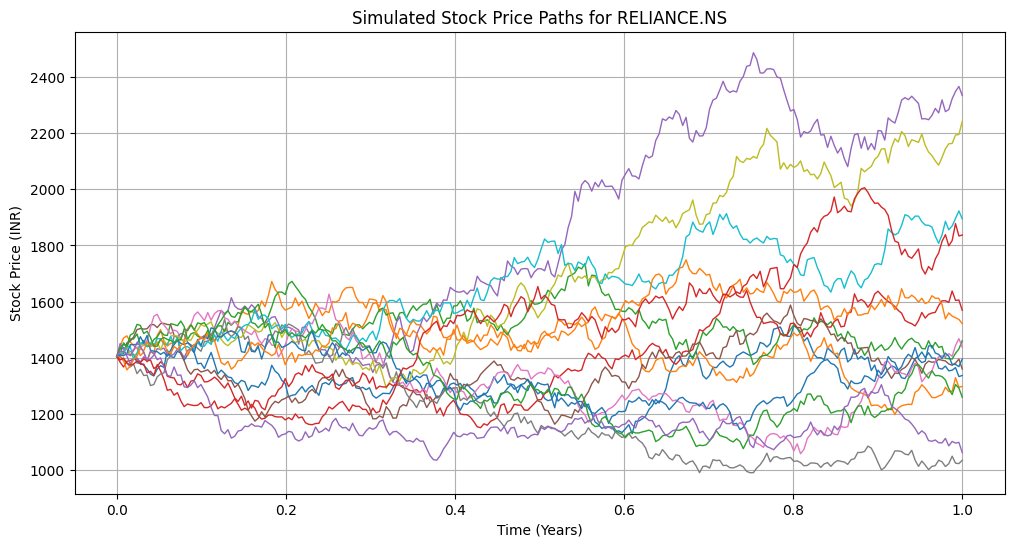

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch current data for Reliance Industries
ticker = 'RELIANCE.NS'
stock = yf.Ticker(ticker)
data = stock.history(period='1y')

# Current stock price and volatility
S0 = data['Close'][-1]
daily_returns = data['Close'].pct_change().dropna()
sigma = np.std(daily_returns) * np.sqrt(252)  # Annualized volatility
r = 0.06  # Risk-free rate of India
T = 1  # Time horizon in years
n_steps = 252  # Daily steps
n_simulations = 15  # Number of paths to simulate

# Time array
dt = T / n_steps
time = np.linspace(0, T, n_steps)

# Simulate paths
simulated_paths = np.zeros((n_steps, n_simulations))
for i in range(n_simulations):
    prices = [S0]
    for t in range(1, n_steps):
        z = np.random.normal()
        price = prices[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
        prices.append(price)
    simulated_paths[:, i] = prices

# Plotting the simulated paths
plt.figure(figsize=(12, 6))
for i in range(n_simulations):
    plt.plot(time, simulated_paths[:, i], lw=1)
plt.title(f'Simulated Stock Price Paths for {ticker}')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price (INR)')
plt.grid(True)
plt.show()
